In [16]:
"""
Task 0: Data Overview and Preprocessing for iDEM Research Task

This script provides:
    1. Data download and validation
    2. Duplicate detection and reporting
    3. Cleaned dataset generation (En-Dataset_cleaned.csv, Fr-Dataset_cleaned.csv)
    4. Comprehensive statistics and visualizations using CLEANED data

Official Label Definition (from README):
    - Label = 0: Simple (sentence annotated as simple, from Vikidia)
    - Label = 1: Complex (sentence annotated as complex, from Wikipedia)

Source (derived from ID prefix):
    - wiki-* : Wikipedia
    - viki-* : Vikidia

Cleaning Strategy (aligned with feature_extraction_kaggle_multi.py):
    1. Basic cleaning: Remove NaN and blank sentences
    2. V-V: Remove Vikidia internal duplicates (keep first occurrence)
    3. W-W: Remove Wikipedia internal duplicates (keep first occurrence)
    4. V-W: Remove cross-dataset duplicates from Vikidia (keep Wikipedia version)
         This prevents data leakage between train/test sets.

Duplicate Types (for reporting):
    - V-V: Vikidia internal duplicates
    - V-W: Cross-dataset duplicates (Vikidia ∩ Wikipedia)
    - W-W: Wikipedia internal duplicates

Output Files:
    - data/En-Dataset_cleaned.csv
    - data/Fr-Dataset_cleaned.csv
    - output/en_duplicates.csv (duplicate report)
    - output/fr_duplicates.csv (duplicate report)
    - output/*.png (visualizations)

Usage:
    python 01_data_overview.py
"""

'\nTask 0: Data Overview and Preprocessing for iDEM Research Task\n\nThis script provides:\n    1. Data download and validation\n    2. Duplicate detection and reporting\n    3. Cleaned dataset generation (En-Dataset_cleaned.csv, Fr-Dataset_cleaned.csv)\n    4. Comprehensive statistics and visualizations using CLEANED data\n\nOfficial Label Definition (from README):\n    - Label = 0: Simple (sentence annotated as simple, from Vikidia)\n    - Label = 1: Complex (sentence annotated as complex, from Wikipedia)\n\nSource (derived from ID prefix):\n    - wiki-* : Wikipedia\n    - viki-* : Vikidia\n\nCleaning Strategy (aligned with feature_extraction_kaggle_multi.py):\n    1. Basic cleaning: Remove NaN and blank sentences\n    2. V-V: Remove Vikidia internal duplicates (keep first occurrence)\n    3. W-W: Remove Wikipedia internal duplicates (keep first occurrence)\n    4. V-W: Remove cross-dataset duplicates from Vikidia (keep Wikipedia version)\n         This prevents data leakage between 

In [17]:
import os
from pathlib import Path
import shutil
import textwrap
import urllib.request
import urllib.error
from collections import defaultdict
from typing import Dict, List, Set, Tuple

In [18]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm

In [19]:
# For Jupyter Notebook (use current working directory)
BASE_DIR = Path(os.getcwd())
DATA_DIR = BASE_DIR / "data"
OUTPUT_DIR = BASE_DIR / "output"

In [20]:
DATA_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

In [21]:
DATA_URLS = {
    "En-Dataset.csv": "https://github.com/Nouran-Khallaf/idem-candidate-task/releases/download/data/En-Dataset.csv",
    "Fr-Dataset.csv": "https://github.com/Nouran-Khallaf/idem-candidate-task/releases/download/data/Fr-Dataset.csv",
}

In [22]:
# Official label semantics
LABEL_NAMES = {0: "Simple", 1: "Complex"}

In [23]:
# File Search and Download
class DownloadProgressBar:
    """Progress bar for urllib downloads."""
    
    def __init__(self, filename: str):
        self.pbar = None
        self.filename = filename
    
    def __call__(self, block_num: int, block_size: int, total_size: int):
        if self.pbar is None:
            self.pbar = tqdm(
                total=total_size,
                unit='B',
                unit_scale=True,
                unit_divisor=1024,
                desc=f"Downloading {self.filename}",
                ncols=80
            )
        downloaded = block_num * block_size
        if downloaded < total_size:
            self.pbar.update(block_size)
        else:
            self.pbar.close()

In [24]:
def find_file_recursive(filename: str, search_dir: Path, max_depth: int = 3) -> Path | None:
    """
    Recursively search for a file in the given directory and subdirectories.
    
    Args:
        filename: Name of the file to find
        search_dir: Directory to start searching from
        max_depth: Maximum depth to search (default: 3)
    
    Returns:
        Path to the file if found, None otherwise
    """
    target = search_dir / filename
    if target.exists():
        return target
    
    if max_depth > 0:
        try:
            for subdir in search_dir.iterdir():
                if subdir.is_dir() and not subdir.name.startswith('.'):
                    result = find_file_recursive(filename, subdir, max_depth - 1)
                    if result:
                        return result
        except PermissionError:
            pass
    
    return None

In [25]:
def ensure_data_exists() -> None:
    """
    Check if dataset files exist locally. Search in current directory,
    subdirectories, and data/ folder. If not found, download from GitHub.
    """
    print("\nChecking dataset files...")

    for filename, url in DATA_URLS.items():
        target_path = DATA_DIR / filename

        if target_path.exists():
            print(f"  Found: {target_path}")
            continue

        print(f"  Searching for {filename}...")
        found_path = find_file_recursive(filename, BASE_DIR)

        if found_path:
            print(f"  Found: {found_path}")
            if found_path != target_path:
                print(f"  Copying to: {target_path}")
                shutil.copy2(found_path, target_path)
            continue

        print(f"  File not found locally: {filename}")
        print(f"  Downloading from GitHub...")

        try:
            progress_bar = DownloadProgressBar(filename)
            urllib.request.urlretrieve(url, target_path, reporthook=progress_bar)
            print(f"  Download complete: {target_path}")
        except urllib.error.URLError as e:
            raise RuntimeError(
                f"Failed to download {filename}: {e}\n"
                f"Please manually download the file from:\n"
                f"  {url}\n"
                f"and place it in: {DATA_DIR}/"
            )
        except PermissionError as e:
            raise RuntimeError(
                f"Permission denied when writing to {target_path}: {e}\n"
                f"Please check write permissions for: {DATA_DIR}/"
            )

In [26]:
# Data Loading
def load_raw_data(lang: str) -> pd.DataFrame:
    """Load raw dataset for specified language."""
    filename = "En-Dataset.csv" if lang == 'en' else "Fr-Dataset.csv"
    filepath = DATA_DIR / filename
    return pd.read_csv(filepath)

In [27]:
def load_cleaned_data(lang: str) -> pd.DataFrame:
    """
    Load cleaned dataset for specified language.
    Adds 'source' column if not present.
    """
    lang_prefix = 'En' if lang == 'en' else 'Fr'
    filename = f"{lang_prefix}-Dataset_cleaned.csv"
    filepath = DATA_DIR / filename
    
    if not filepath.exists():
        raise FileNotFoundError(f"Cleaned dataset not found: {filepath}")
    
    df = pd.read_csv(filepath)
    
    # Add source column if not present
    if 'source' not in df.columns:
        df['source'] = df['ID'].apply(
            lambda x: 'wiki' if str(x).lower().startswith('wiki') else 'viki'
        )
    
    return df

In [28]:
# Duplicate Detection (Integrated from detect_duplicates.py)
def assign_unique_index(df: pd.DataFrame) -> pd.DataFrame:
    """Assign unique Index as first column."""
    print("  Assigning unique Index...")
    
    df = df.copy()
    df['source'] = df['ID'].apply(
        lambda x: 'viki' if str(x).lower().startswith('viki') else 'wiki'
    )
    
    viki_mask = df['source'] == 'viki'
    wiki_mask = df['source'] == 'wiki'
    
    df.loc[viki_mask, 'Index'] = [f"viki-{i:06d}" for i in range(1, viki_mask.sum() + 1)]
    df.loc[wiki_mask, 'Index'] = [f"wiki-{i:06d}" for i in range(1, wiki_mask.sum() + 1)]
    
    cols = ['Index'] + [c for c in df.columns if c != 'Index']
    df = df[cols]
    
    print(f"    Vikidia: {viki_mask.sum():,}")
    print(f"    Wikipedia: {wiki_mask.sum():,}")
    
    return df

In [29]:
def detect_duplicates(df: pd.DataFrame) -> Tuple[pd.DataFrame, Dict]:
    """
    Detect duplicates and assign dup_type_1, dup_type_2.
    
    Duplicate types:
        - V-V: Vikidia internal duplicates
        - V-W: Cross-dataset duplicates (Vikidia and Wikipedia)
        - W-W: Wikipedia internal duplicates
    
    Priority: V-W > V-V > W-W
    """
    print("  Detecting duplicates...")
    
    # Group sentences by text
    sentence_to_indices: Dict[str, List[str]] = defaultdict(list)
    index_to_source: Dict[str, str] = {}
    
    for _, row in tqdm(df.iterrows(), total=len(df), desc="    Grouping sentences"):
        sent = row['Sentence']
        idx = row['Index']
        source = row['source']
        sentence_to_indices[sent].append(idx)
        index_to_source[idx] = source
    
    # Find duplicate types for each Index
    index_dup_types: Dict[str, Set[str]] = defaultdict(set)
    
    for sent, indices in tqdm(sentence_to_indices.items(), desc="    Classifying duplicates"):
        if len(indices) < 2:
            continue
        
        sources = [index_to_source[idx] for idx in indices]
        has_viki = 'viki' in sources
        has_wiki = 'wiki' in sources
        viki_count = sources.count('viki')
        wiki_count = sources.count('wiki')
        
        for idx in indices:
            src = index_to_source[idx]
            
            if has_viki and has_wiki:
                index_dup_types[idx].add('V-W')
            
            if src == 'viki' and viki_count >= 2:
                index_dup_types[idx].add('V-V')
            
            if src == 'wiki' and wiki_count >= 2:
                index_dup_types[idx].add('W-W')
    
    # Build result DataFrame
    dup_indices = set(index_dup_types.keys())
    dup_df = df[df['Index'].isin(dup_indices)].copy()
    
    # Assign dup_type_1 and dup_type_2 with priority
    priority = {'V-W': 1, 'V-V': 2, 'W-W': 3}
    
    def get_dup_types(idx: str) -> Tuple[str, str]:
        types = index_dup_types.get(idx, set())
        if not types:
            return ('', '')
        sorted_types = sorted(types, key=lambda x: priority.get(x, 99))
        type1 = sorted_types[0] if len(sorted_types) >= 1 else ''
        type2 = sorted_types[1] if len(sorted_types) >= 2 else ''
        return (type1, type2)
    
    dup_df['dup_type_1'] = dup_df['Index'].apply(lambda x: get_dup_types(x)[0])
    dup_df['dup_type_2'] = dup_df['Index'].apply(lambda x: get_dup_types(x)[1])
    
    # Statistics
    stats = {
        'total_duplicates': len(dup_df),
        'vv_only': ((dup_df['dup_type_1'] == 'V-V') & (dup_df['dup_type_2'] == '')).sum(),
        'vw_only': ((dup_df['dup_type_1'] == 'V-W') & (dup_df['dup_type_2'] == '')).sum(),
        'ww_only': ((dup_df['dup_type_1'] == 'W-W') & (dup_df['dup_type_2'] == '')).sum(),
        'multiple_types': (dup_df['dup_type_2'] != '').sum()
    }
    
    print(f"\n    Total duplicate rows: {stats['total_duplicates']:,}")
    print(f"    V-V only: {stats['vv_only']:,}")
    print(f"    V-W only: {stats['vw_only']:,}")
    print(f"    W-W only: {stats['ww_only']:,}")
    print(f"    Multiple types: {stats['multiple_types']:,}")
    
    return dup_df, stats

In [30]:
def basic_cleaning(df: pd.DataFrame) -> Tuple[pd.DataFrame, Dict]:
    """
    Basic cleaning: remove NaN and blank sentences.
    
    This aligns with the feature_extraction_kaggle_multi.py pipeline.
    """
    print("  Basic cleaning...")
    
    stats = {'original_rows': len(df)}
    
    # Drop NaN in critical columns
    critical_cols = ['Index', 'Sentence', 'Label']
    nan_before = len(df)
    df = df.dropna(subset=critical_cols)
    stats['nan_removed'] = nan_before - len(df)
    print(f"    NaN removed: {stats['nan_removed']:,}")
    
    # Remove blank sentences
    blank_before = len(df)
    df = df[df['Sentence'].str.strip().str.len() > 0]
    stats['blank_removed'] = blank_before - len(df)
    print(f"    Blank removed: {stats['blank_removed']:,}")
    
    return df, stats

In [31]:
def create_cleaned_dataset(df: pd.DataFrame) -> Tuple[pd.DataFrame, Dict]:
    """
    Create cleaned dataset using the same logic as feature_extraction_kaggle_multi.py.
    
    Cleaning Strategy:
        1. Basic cleaning: remove NaN and blank sentences
        2. V-V: Remove Vikidia internal duplicates (keep first)
        3. W-W: Remove Wikipedia internal duplicates (keep first)
        4. V-W: Remove cross-dataset duplicates from Vikidia (keep Wikipedia version)
    
    Returns:
        cleaned_df: Cleaned dataset
        stats: Dictionary of cleaning statistics
    """
    print("  Creating cleaned dataset (aligned with feature extraction pipeline)...")
    
    # Step 1: Basic cleaning
    df, stats = basic_cleaning(df)
    
    # Step 2: Split by source
    viki_df = df[df['source'] == 'viki'].copy()
    wiki_df = df[df['source'] == 'wiki'].copy()
    
    print(f"\n    Before duplicate removal:")
    print(f"      Vikidia: {len(viki_df):,}")
    print(f"      Wikipedia: {len(wiki_df):,}")
    
    # Step 3a: Vikidia internal duplicates (V-V)
    viki_before = len(viki_df)
    viki_df = viki_df.drop_duplicates(subset=['Sentence'], keep='first')
    stats['viki_internal_dup'] = viki_before - len(viki_df)
    print(f"    V-V (Vikidia internal duplicates): {stats['viki_internal_dup']:,}")
    
    # Step 3b: Wikipedia internal duplicates (W-W)
    wiki_before = len(wiki_df)
    wiki_df = wiki_df.drop_duplicates(subset=['Sentence'], keep='first')
    stats['wiki_internal_dup'] = wiki_before - len(wiki_df)
    print(f"    W-W (Wikipedia internal duplicates): {stats['wiki_internal_dup']:,}")
    
    # Step 3c: Cross-dataset leakage (V-W) - remove from Vikidia
    wiki_sentences = set(wiki_df['Sentence'].values)
    leakage_mask = viki_df['Sentence'].isin(wiki_sentences)
    stats['leakage_removed'] = int(leakage_mask.sum())
    viki_df = viki_df[~leakage_mask]
    print(f"    V-W (Leakage, removed from Vikidia): {stats['leakage_removed']:,}")
    
    # Combine back
    cleaned_df = pd.concat([viki_df, wiki_df], ignore_index=True)
    cleaned_df = cleaned_df.sort_values('Index').reset_index(drop=True)
    
    # Keep only output columns
    output_cols = ['Index', 'ID', 'Name', 'Sentence', 'Label', 'LengthWords', 'LengthChars']
    output_cols = [c for c in output_cols if c in cleaned_df.columns]
    cleaned_df = cleaned_df[output_cols]
    
    stats['after_dedup'] = len(cleaned_df)
    stats['viki_final'] = len(viki_df)
    stats['wiki_final'] = len(wiki_df)
    
    n_removed = stats['original_rows'] - len(cleaned_df)
    print(f"\n    Original rows: {stats['original_rows']:,}")
    print(f"    Total removed: {n_removed:,}")
    print(f"    Cleaned rows: {len(cleaned_df):,}")
    print(f"      Vikidia: {stats['viki_final']:,}")
    print(f"      Wikipedia: {stats['wiki_final']:,}")
    
    return cleaned_df, stats

In [32]:
def preprocess_dataset(lang: str) -> Tuple[pd.DataFrame, pd.DataFrame, Dict]:
    """
    Complete preprocessing pipeline for one language.
    
    Pipeline (aligned with feature_extraction_kaggle_multi.py):
        1. Load raw data
        2. Assign unique index
        3. Detect duplicates (for reporting only)
        4. Create cleaned dataset:
           - Basic cleaning (NaN, blank)
           - V-V removal
           - W-W removal
           - V-W leakage removal (from Vikidia)
    
    Returns:
        cleaned_df: Cleaned dataset
        dup_df: DataFrame of duplicates (for analysis)
        stats: Dictionary of statistics
    """
    print(f"\n{'='*60}")
    print(f"PREPROCESSING {lang.upper()} DATASET")
    print("=" * 60)
    
    # Load raw data
    print(f"\nLoading raw data...")
    raw_df = load_raw_data(lang)
    print(f"  Loaded {len(raw_df):,} rows")
    
    # Assign unique index
    indexed_df = assign_unique_index(raw_df)
    
    # Detect duplicates (for reporting - uses original data before cleaning)
    dup_df, dup_stats = detect_duplicates(indexed_df)
    
    # Create cleaned dataset (with new cleaning logic)
    cleaned_df, cleaning_stats = create_cleaned_dataset(indexed_df)
    
    # Merge stats
    all_stats = {**dup_stats, **cleaning_stats}
    
    # Save outputs
    lang_prefix = 'En' if lang == 'en' else 'Fr'
    
    # Save duplicates report
    dup_output = OUTPUT_DIR / f"{lang}_duplicates.csv"
    output_cols = ['Index', 'ID', 'Name', 'Sentence', 'Label', 
                   'LengthWords', 'LengthChars', 'dup_type_1', 'dup_type_2']
    output_cols = [c for c in output_cols if c in dup_df.columns]
    dup_df[output_cols].to_csv(dup_output, index=False)
    print(f"\n  Saved duplicates report: {dup_output}")
    
    # Save cleaned dataset
    cleaned_output = DATA_DIR / f"{lang_prefix}-Dataset_cleaned.csv"
    cleaned_df.to_csv(cleaned_output, index=False)
    print(f"  Saved cleaned dataset: {cleaned_output}")
    
    # Print cleaning summary
    print(f"\n  Cleaning Summary:")
    print(f"    NaN removed: {cleaning_stats.get('nan_removed', 0):,}")
    print(f"    Blank removed: {cleaning_stats.get('blank_removed', 0):,}")
    print(f"    V-V duplicates removed: {cleaning_stats.get('viki_internal_dup', 0):,}")
    print(f"    W-W duplicates removed: {cleaning_stats.get('wiki_internal_dup', 0):,}")
    print(f"    V-W leakage removed: {cleaning_stats.get('leakage_removed', 0):,}")
    
    return cleaned_df, dup_df, all_stats

In [33]:
# Statistics Functions (Using Cleaned Data)
def print_descriptive_statistics(name: str, df: pd.DataFrame) -> None:
    """Print descriptive statistics using pandas describe()."""
    print(f"\n{name} Descriptive Statistics (Cleaned Data)")
    print("=" * 50)
    print(df.describe().to_string())

In [34]:
def label_distribution(df: pd.DataFrame) -> pd.Series:
    """Return label counts sorted by label."""
    return df["Label"].value_counts().sort_index()

In [35]:
def compute_iqr(df: pd.DataFrame, column: str = "LengthWords") -> Tuple[float, float]:
    """Return the (Q1, Q3) interquartile range for specified column."""
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    return q1, q3

In [36]:
def summarize_dataset(name: str, df: pd.DataFrame) -> dict:
    """
    Generate summary statistics for a cleaned dataset.
    
    Uses official label semantics:
        - Label = 0: Simple
        - Label = 1: Complex
    """
    total_sentences = len(df)
    
    # Add source if not present
    if 'source' not in df.columns:
        df = df.copy()
        df['source'] = df['ID'].apply(
            lambda x: 'wiki' if str(x).lower().startswith('wiki') else 'viki'
        )
    
    # Statistics by Label (complexity)
    n_simple = (df['Label'] == 0).sum()
    n_complex = (df['Label'] == 1).sum()
    
    # Statistics by Source
    n_wiki = (df['source'] == 'wiki').sum()
    n_viki = (df['source'] == 'viki').sum()
    
    print(f"\n{name} Dataset (Cleaned)")
    print("=" * (len(name) + 18))
    print(f"Total sentences: {total_sentences:,}")
    
    print(f"\nBy Complexity (Label):")
    print(f"  Simple (Label=0):  {n_simple:,} ({n_simple/total_sentences*100:.2f}%)")
    print(f"  Complex (Label=1): {n_complex:,} ({n_complex/total_sentences*100:.2f}%)")
    
    print(f"\nBy Source:")
    print(f"  Wikipedia: {n_wiki:,} ({n_wiki/total_sentences*100:.2f}%)")
    print(f"  Vikidia:   {n_viki:,} ({n_viki/total_sentences*100:.2f}%)")
    
    # Cross-tabulation
    print(f"\nCross-tabulation (Source x Label):")
    cross_tab = pd.crosstab(df['source'], df['Label'], margins=True)
    cross_tab.columns = ['Simple(0)', 'Complex(1)', 'Total']
    cross_tab.index = ['viki', 'wiki', 'Total']
    print(cross_tab.to_string())
    
    print("\nIQR for LengthWords:")
    subsets = [
        ("all", df),
        ("Simple (Label=0)", df[df["Label"] == 0]),
        ("Complex (Label=1)", df[df["Label"] == 1]),
    ]

    iqr_results = {}
    for subset_name, subset_df in subsets:
        if subset_df.empty:
            print(f"  {subset_name}: no data")
            continue
        q1, q3 = compute_iqr(subset_df)
        iqr_results[subset_name] = (q1, q3)
        print(f"  {subset_name}: Q1={q1:.0f}, Q3={q3:.0f}")

    return {
        "total_sentences": total_sentences,
        "n_simple": n_simple,
        "n_complex": n_complex,
        "n_wiki": n_wiki,
        "n_viki": n_viki,
        "iqr": iqr_results,
    }

In [37]:
# Visualization Functions (Using Cleaned Data)
def plot_descriptive_statistics(
    en_df: pd.DataFrame, fr_df: pd.DataFrame, output_dir: Path
) -> None:
    """Generate a table image of descriptive statistics."""
    en_desc = en_df.describe().round(2)
    fr_desc = fr_df.describe().round(2)

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle(
        "Descriptive Statistics (Cleaned Data)",
        fontsize=14,
        fontweight="bold",
        y=0.98,
    )

    axes[0].axis("off")
    axes[0].set_title("English Dataset", fontsize=12, fontweight="bold")
    en_table = axes[0].table(
        cellText=en_desc.values,
        rowLabels=en_desc.index,
        colLabels=en_desc.columns,
        cellLoc="center",
        loc="center",
    )
    en_table.auto_set_font_size(False)
    en_table.set_fontsize(9)
    en_table.scale(1.2, 1.5)

    axes[1].axis("off")
    axes[1].set_title("French Dataset", fontsize=12, fontweight="bold")
    fr_table = axes[1].table(
        cellText=fr_desc.values,
        rowLabels=fr_desc.index,
        colLabels=fr_desc.columns,
        cellLoc="center",
        loc="center",
    )
    fr_table.auto_set_font_size(False)
    fr_table.set_fontsize(9)
    fr_table.scale(1.2, 1.5)

    plt.tight_layout()
    plt.savefig(output_dir / "descriptive_statistics.png", dpi=150, bbox_inches="tight")
    plt.show()

    print(f"Saved: {output_dir}/descriptive_statistics.png")

In [38]:
def plot_summary_statistics(
    en_df: pd.DataFrame, fr_df: pd.DataFrame, output_dir: Path
) -> None:
    """Generate a table image of summary statistics."""
    summary_data = []

    for name, df in [("English", en_df), ("French", fr_df)]:
        total = len(df)
        # Label=0 is Simple, Label=1 is Complex
        n_simple = (df["Label"] == 0).sum()
        n_complex = (df["Label"] == 1).sum()
        pct_simple = n_simple / total * 100
        pct_complex = n_complex / total * 100

        q1_all, q3_all = compute_iqr(df)
        q1_simple, q3_simple = compute_iqr(df[df["Label"] == 0])
        q1_complex, q3_complex = compute_iqr(df[df["Label"] == 1])

        summary_data.append([
            name,
            f"{total:,}",
            f"{n_simple:,} ({pct_simple:.2f}%)",
            f"{n_complex:,} ({pct_complex:.2f}%)",
            f"Q1={q1_all:.0f}, Q3={q3_all:.0f}",
            f"Q1={q1_simple:.0f}, Q3={q3_simple:.0f}",
            f"Q1={q1_complex:.0f}, Q3={q3_complex:.0f}",
        ])

    col_labels = [
        "Dataset",
        "Total Sentences",
        "Simple (Label=0)",
        "Complex (Label=1)",
        "IQR (all)",
        "IQR (Simple)",
        "IQR (Complex)",
    ]

    fig, ax = plt.subplots(figsize=(16, 3))
    fig.suptitle(
        "Dataset Summary Statistics (Cleaned Data)",
        fontsize=14,
        fontweight="bold",
        y=0.95,
    )
    ax.axis("off")

    table = ax.table(
        cellText=summary_data,
        colLabels=col_labels,
        cellLoc="center",
        loc="center",
    )
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 2.0)

    for j in range(len(col_labels)):
        table[(0, j)].set_facecolor("#4472C4")
        table[(0, j)].set_text_props(color="white", fontweight="bold")

    plt.tight_layout()
    plt.savefig(output_dir / "summary_statistics.png", dpi=150, bbox_inches="tight")
    plt.show()

    print(f"Saved: {output_dir}/summary_statistics.png")

In [39]:
def plot_length_distributions(
    en_df: pd.DataFrame, fr_df: pd.DataFrame, output_dir: Path
) -> None:
    """Generate unified 2x2 visualization for sentence length distributions."""
    en_plot = en_df.copy()
    fr_plot = fr_df.copy()
    en_plot["Language"] = "English"
    fr_plot["Language"] = "French"

    combined_df = pd.concat(
        [
            en_plot[["Language", "LengthWords", "LengthChars"]],
            fr_plot[["Language", "LengthWords", "LengthChars"]],
        ],
        ignore_index=True,
    )

    sns.set_style("whitegrid")
    colors = {"English": "#3274A1", "French": "#E1812C"}
    palette = [colors["English"], colors["French"]]

    xlim_words = combined_df["LengthWords"].quantile(0.99)
    xlim_chars = combined_df["LengthChars"].quantile(0.99)

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(
        "Sentence Length Distribution (Cleaned Data): English vs French",
        fontsize=14,
        fontweight="bold",
        y=0.98,
    )

    vp1 = sns.violinplot(
        x="Language",
        y="LengthWords",
        data=combined_df,
        ax=axes[0, 0],
        palette=palette,
        inner="quartile",
        cut=0,
    )
    for violin in vp1.collections:
        violin.set_alpha(0.5)
    axes[0, 0].set_title("Distribution by Words")
    axes[0, 0].set_xlabel("")
    axes[0, 0].set_ylabel("Number of Words")
    axes[0, 0].set_ylim(0, xlim_words)

    vp2 = sns.violinplot(
        x="Language",
        y="LengthChars",
        data=combined_df,
        ax=axes[0, 1],
        palette=palette,
        inner="quartile",
        cut=0,
    )
    for violin in vp2.collections:
        violin.set_alpha(0.5)
    axes[0, 1].set_title("Distribution by Characters")
    axes[0, 1].set_xlabel("")
    axes[0, 1].set_ylabel("Number of Characters")
    axes[0, 1].set_ylim(0, xlim_chars)

    sns.histplot(
        en_plot["LengthWords"],
        bins=50,
        stat="density",
        kde=True,
        ax=axes[1, 0],
        color=colors["English"],
        label="English",
        alpha=0.5,
        linewidth=1.5,
    )
    sns.histplot(
        fr_plot["LengthWords"],
        bins=50,
        stat="density",
        kde=True,
        ax=axes[1, 0],
        color=colors["French"],
        label="French",
        alpha=0.5,
        linewidth=1.5,
    )
    axes[1, 0].set_title("Density Distribution by Words")
    axes[1, 0].set_xlabel("Number of Words")
    axes[1, 0].set_ylabel("Density")
    axes[1, 0].set_xlim(0, xlim_words)
    axes[1, 0].legend()

    sns.histplot(
        en_plot["LengthChars"],
        bins=50,
        stat="density",
        kde=True,
        ax=axes[1, 1],
        color=colors["English"],
        label="English",
        alpha=0.5,
        linewidth=1.5,
    )
    sns.histplot(
        fr_plot["LengthChars"],
        bins=50,
        stat="density",
        kde=True,
        ax=axes[1, 1],
        color=colors["French"],
        label="French",
        alpha=0.5,
        linewidth=1.5,
    )
    axes[1, 1].set_title("Density Distribution by Characters")
    axes[1, 1].set_xlabel("Number of Characters")
    axes[1, 1].set_ylabel("Density")
    axes[1, 1].set_xlim(0, xlim_chars)
    axes[1, 1].legend()

    plt.tight_layout()
    plt.savefig(output_dir / "length_distributions.png", dpi=150)
    plt.show()

    print(f"Saved: {output_dir}/length_distributions.png")

In [40]:
def plot_label_source_analysis(
    en_df: pd.DataFrame, fr_df: pd.DataFrame, output_dir: Path
) -> None:
    """
    Visualize the relationship between Label and Source.
    This reveals that Label = Source in the original data.
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle(
        "Label vs Source Analysis (Cleaned Data)",
        fontsize=14,
        fontweight="bold",
        y=0.98,
    )
    
    for idx, (name, df) in enumerate([("English", en_df), ("French", fr_df)]):
        df_copy = df.copy()
        if 'source' not in df_copy.columns:
            df_copy['source'] = df_copy['ID'].apply(
                lambda x: 'wiki' if str(x).lower().startswith('wiki') else 'viki'
            )
        
        cross_tab = pd.crosstab(df_copy['source'], df_copy['Label'])
        cross_tab.columns = ['Simple (0)', 'Complex (1)']
        cross_tab.index = ['Vikidia', 'Wikipedia']
        
        sns.heatmap(
            cross_tab,
            annot=True,
            fmt=',d',
            cmap='Blues',
            ax=axes[idx],
            cbar=True
        )
        axes[idx].set_title(f"{name}: Source x Label", fontsize=12, fontweight="bold")
        axes[idx].set_xlabel("Label (Complexity)")
        axes[idx].set_ylabel("Source")
    
    plt.tight_layout()
    plt.savefig(output_dir / "label_source_analysis.png", dpi=150)
    plt.show()
    
    print(f"Saved: {output_dir}/label_source_analysis.png")

In [41]:
def inspect_samples(
    en_df: pd.DataFrame, fr_df: pd.DataFrame, output_dir: Path, n_samples: int = 10
) -> None:
    """Display sample sentences from each label category and save as image."""
    print("\n" + "=" * 60)
    print("Sample Sentences Inspection")
    print("=" * 60)

    for name, df in [("English", en_df), ("French", fr_df)]:
        print(f"\n{name} samples:")
        print("-" * 40)

        sample_texts = []

        for label in [0, 1]:
            label_name = LABEL_NAMES[label]
            subset = df[df["Label"] == label]
            samples = subset.sample(n=min(n_samples, len(subset)), random_state=42)

            print(f"\nLabel {label} ({label_name}):")
            sample_texts.append(f"Label {label} ({label_name}):")
            sample_texts.append("-" * 50)

            for idx, row in samples.iterrows():
                sentence = row["Sentence"]
                line = f"[{row['LengthWords']} words] {sentence}"
                print(f"  {line[:100]}...")
                sample_texts.append(line)

            sample_texts.append("")

        fig, ax = plt.subplots(figsize=(16, 14))
        fig.suptitle(
            f"Sample Sentences: {name} (Cleaned Data)",
            fontsize=14,
            fontweight="bold",
            y=0.98,
        )
        ax.axis("off")

        wrapped_lines = []
        for line in sample_texts:
            if line.startswith("["):
                wrapped = textwrap.fill(line, width=100)
                wrapped_lines.append(wrapped)
            else:
                wrapped_lines.append(line)

        full_text = "\n".join(wrapped_lines)
        ax.text(
            0.02,
            0.98,
            full_text,
            transform=ax.transAxes,
            fontsize=9,
            fontfamily="monospace",
            verticalalignment="top",
            horizontalalignment="left",
        )

        plt.tight_layout()
        filename = f"sample_sentences_{name.lower()}.png"
        plt.savefig(output_dir / filename, dpi=150, bbox_inches="tight")
        plt.show()

        print(f"Saved: {output_dir}/{filename}")

In [42]:
# Main Entry Point
def main() -> None:
    """Main entry point for Task 0 data overview."""
    print("\n" + "=" * 60)
    print("iDEM TASK 0: DATA OVERVIEW AND PREPROCESSING")
    print("=" * 60)
    print(f"Data directory: {DATA_DIR}")
    print(f"Output directory: {OUTPUT_DIR}")
    print("=" * 60)

    # Ensure raw data files exist
    ensure_data_exists()

    # Check if cleaned datasets already exist
    en_cleaned_path = DATA_DIR / "En-Dataset_cleaned.csv"
    fr_cleaned_path = DATA_DIR / "Fr-Dataset_cleaned.csv"
    
    if en_cleaned_path.exists() and fr_cleaned_path.exists():
        print("\nCleaned datasets already exist.")
        print(f"  {en_cleaned_path}")
        print(f"  {fr_cleaned_path}")
        print("Loading cleaned data for analysis...")
        
        en_df = load_cleaned_data('en')
        fr_df = load_cleaned_data('fr')
        
        print(f"  English: {len(en_df):,} sentences")
        print(f"  French:  {len(fr_df):,} sentences")
    else:
        print("\nCleaned datasets not found. Running preprocessing...")
        
        # Preprocess English
        en_cleaned, en_dup_df, en_dup_stats = preprocess_dataset('en')
        
        # Preprocess French
        fr_cleaned, fr_dup_df, fr_dup_stats = preprocess_dataset('fr')
        
        # Reload with source column
        en_df = load_cleaned_data('en')
        fr_df = load_cleaned_data('fr')

    # Descriptive statistics
    print_descriptive_statistics("English", en_df)
    print_descriptive_statistics("French", fr_df)

    # Summary statistics
    en_stats = summarize_dataset("English", en_df)
    fr_stats = summarize_dataset("French", fr_df)

    # Generate visualizations
    print("\n" + "=" * 60)
    print("GENERATING VISUALIZATIONS")
    print("=" * 60)
    
    plot_descriptive_statistics(en_df, fr_df, OUTPUT_DIR)
    plot_summary_statistics(en_df, fr_df, OUTPUT_DIR)
    plot_length_distributions(en_df, fr_df, OUTPUT_DIR)
    plot_label_source_analysis(en_df, fr_df, OUTPUT_DIR)
    inspect_samples(en_df, fr_df, OUTPUT_DIR, n_samples=10)


    print("\n" + "=" * 60)
    print("TASK 0 COMPLETE!")
    print("=" * 60)
    print(f"\nOutput files:")
    print(f"  - {DATA_DIR}/En-Dataset_cleaned.csv")
    print(f"  - {DATA_DIR}/Fr-Dataset_cleaned.csv")
    print(f"  - {OUTPUT_DIR}/en_duplicates.csv")
    print(f"  - {OUTPUT_DIR}/fr_duplicates.csv")
    print(f"  - {OUTPUT_DIR}/*.png (visualizations)")


iDEM TASK 0: DATA OVERVIEW AND PREPROCESSING
Data directory: c:\Users\chang\iDEMRA\data
Output directory: c:\Users\chang\iDEMRA\output

Checking dataset files...
  Found: c:\Users\chang\iDEMRA\data\En-Dataset.csv
  Found: c:\Users\chang\iDEMRA\data\Fr-Dataset.csv

Cleaned datasets already exist.
  c:\Users\chang\iDEMRA\data\En-Dataset_cleaned.csv
  c:\Users\chang\iDEMRA\data\Fr-Dataset_cleaned.csv
Loading cleaned data for analysis...
  English: 289,781 sentences
  French:  1,653,175 sentences

English Descriptive Statistics (Cleaned Data)
               Label    LengthWords    LengthChars
count  289781.000000  289781.000000  289781.000000
mean        0.940282      23.751795     148.501423
std         0.236963      13.026732      87.278545
min         0.000000       8.000000      33.000000
25%         1.000000      16.000000      96.000000
50%         1.000000      21.000000     131.000000
75%         1.000000      29.000000     180.000000
max         1.000000    2500.000000   17355.00

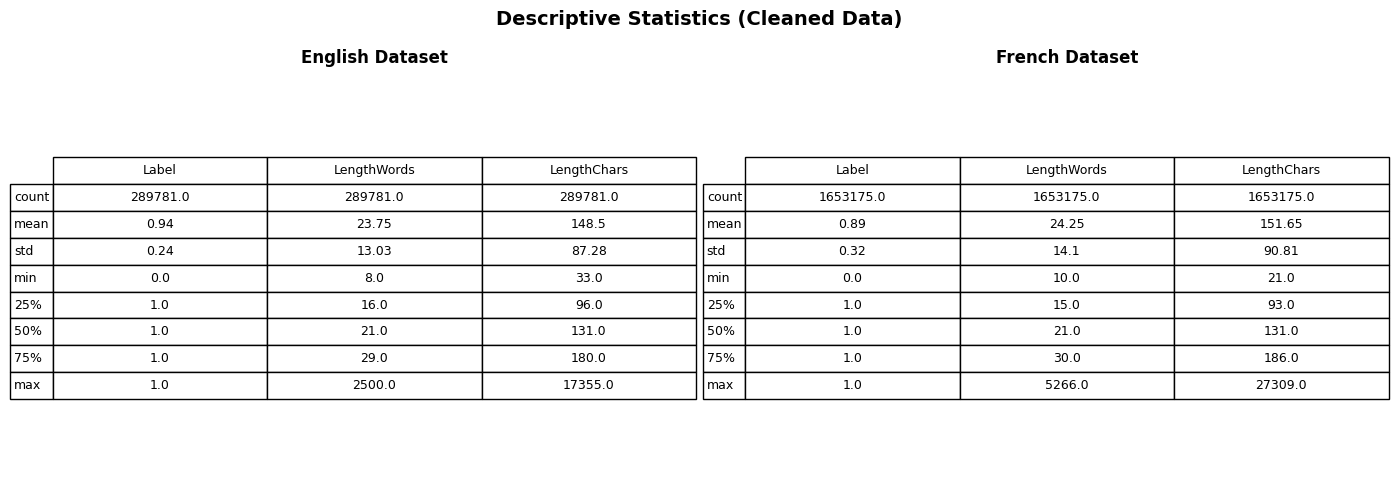

Saved: c:\Users\chang\iDEMRA\output/descriptive_statistics.png


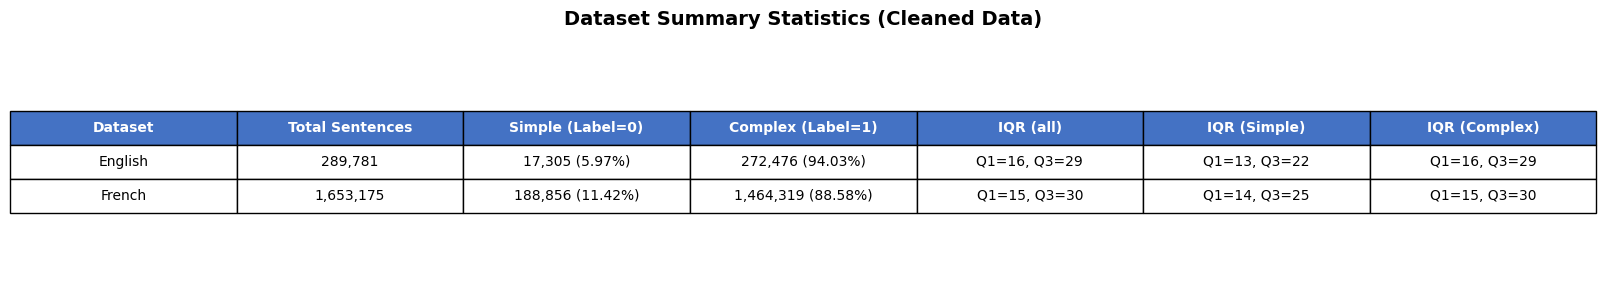

Saved: c:\Users\chang\iDEMRA\output/summary_statistics.png


C:\Users\chang\AppData\Local\Temp\ipykernel_9004\2884575603.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  vp1 = sns.violinplot(
C:\Users\chang\AppData\Local\Temp\ipykernel_9004\2884575603.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  vp2 = sns.violinplot(


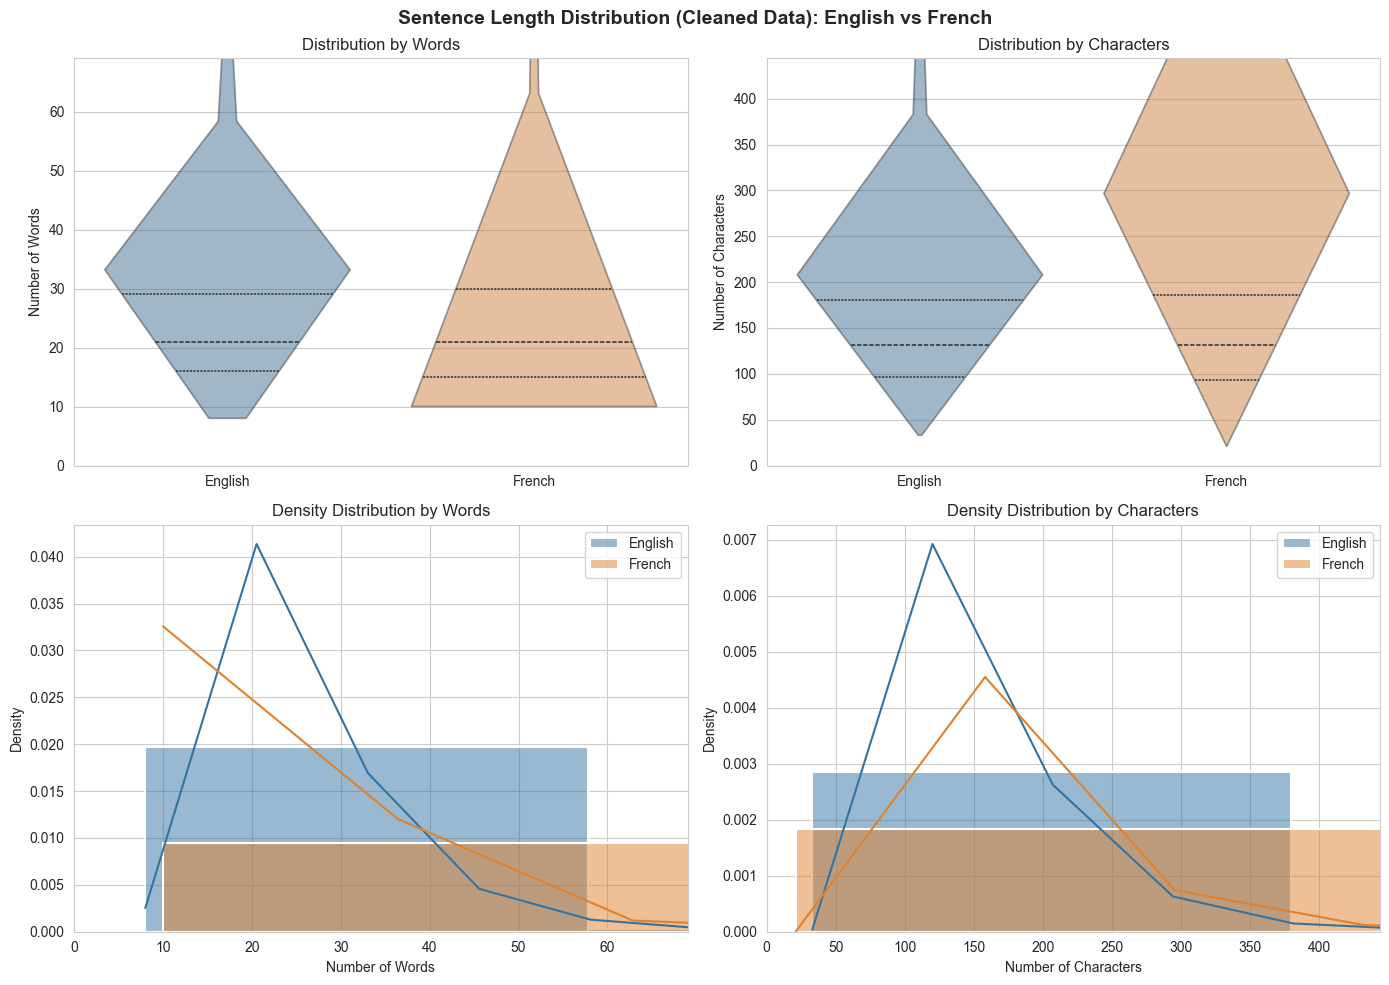

Saved: c:\Users\chang\iDEMRA\output/length_distributions.png


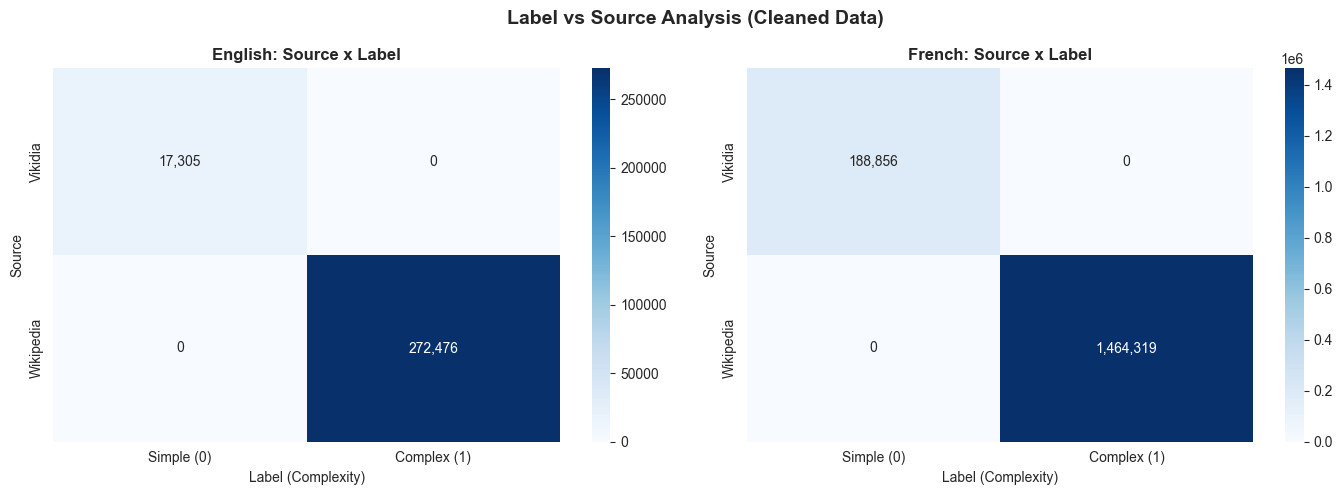

Saved: c:\Users\chang\iDEMRA\output/label_source_analysis.png

Sample Sentences Inspection

English samples:
----------------------------------------

Label 0 (Simple):
  [14 words] The motto of the French Republic is Liberté, Égalité et Fraternité (Liberty, Equality, Fr...
  [18 words] The land was plowed by teams of oxen pulling light unwheeled plows and grain was harveste...
  [10 words] It would be typically found in the woodlands of Asia....
  [14 words] They do not eat or drink from sunrise till sunset for one lunar month....
  [11 words] He died at the age of 41, on June 7, 1954....
  [20 words] For all these reasons, he is considered as the "Father of the Nation" or "Father of the N...
  [13 words] Several buildings in the Art Nouveau style were preserved as a historical heritage....
  [15 words] He has also developed a passion for drama; therefore he was comfortable on the screen....
  [13 words] The toilet has made homes, towns and cities cleaner places to live in....
  [23 w

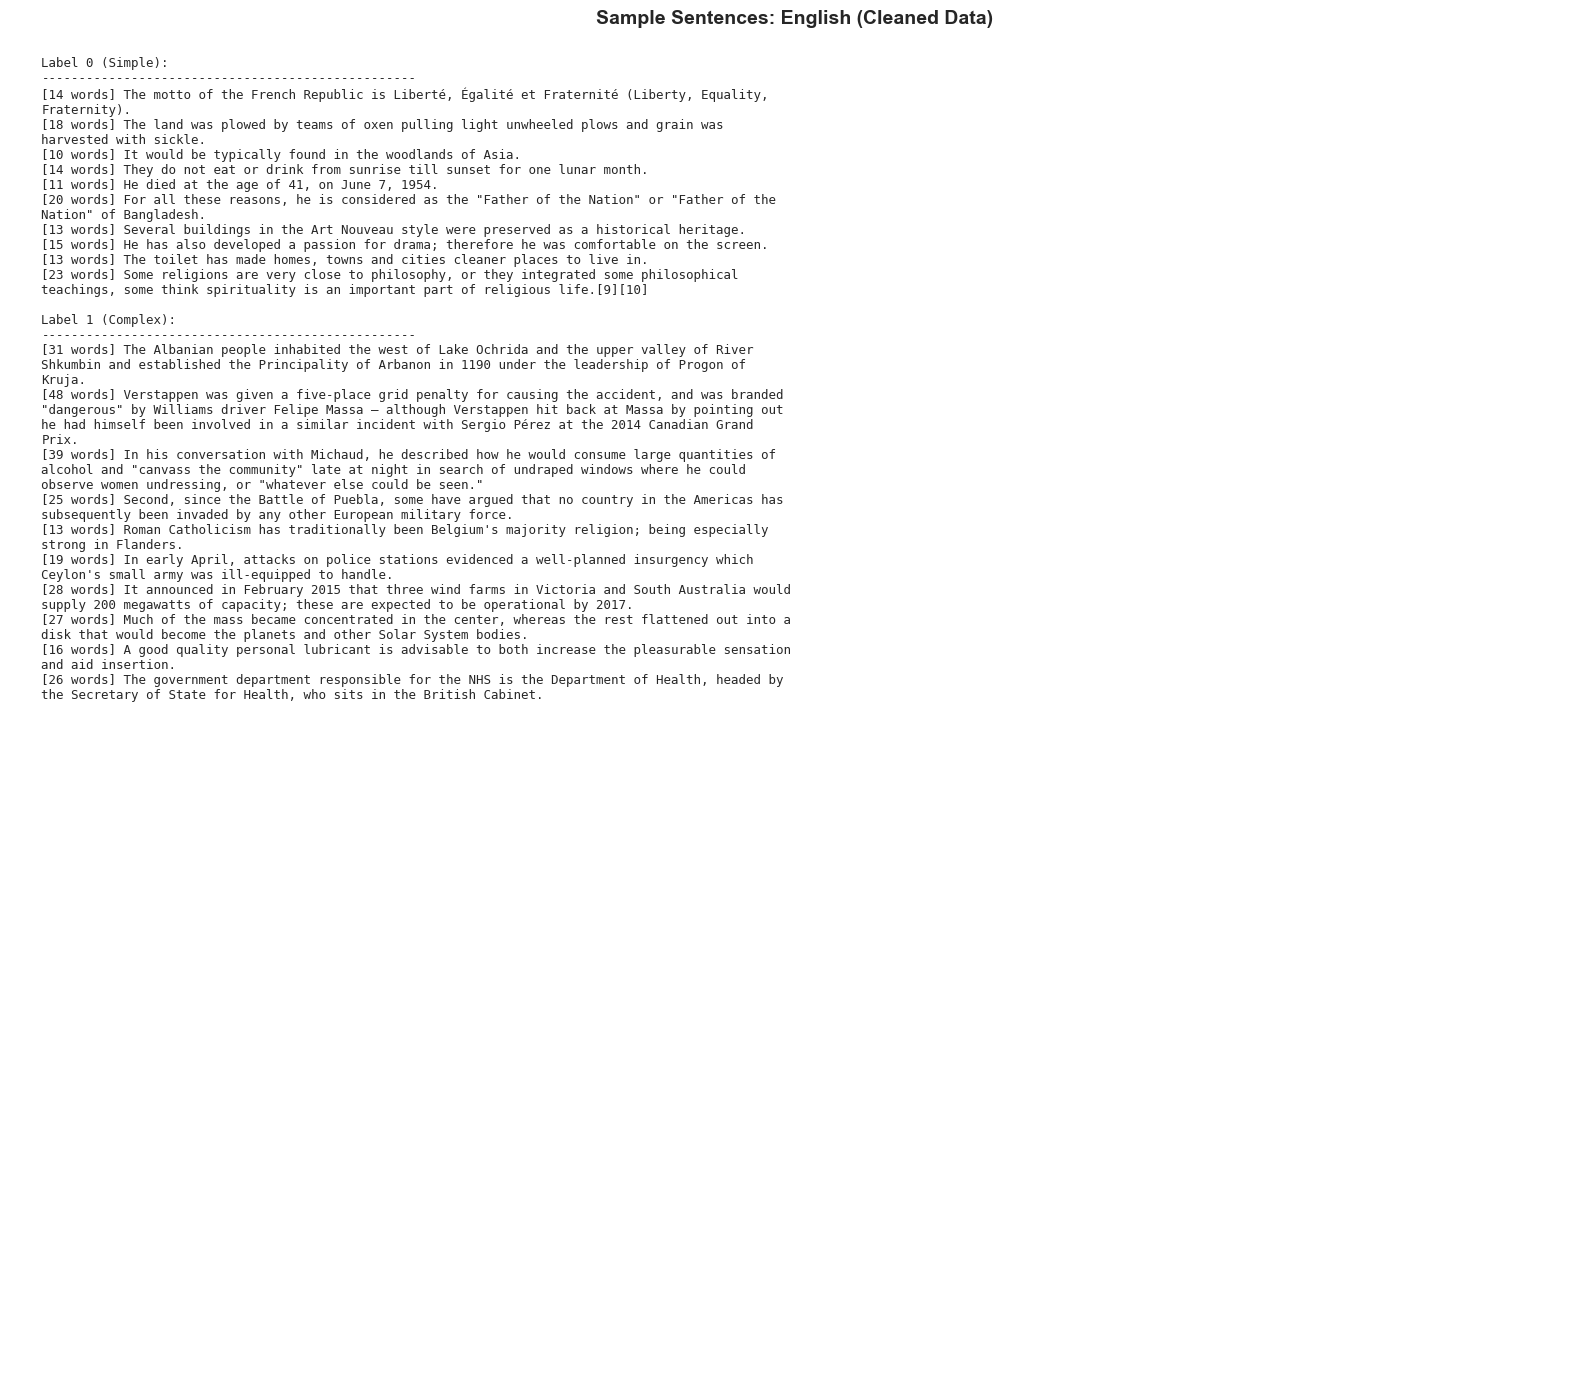

Saved: c:\Users\chang\iDEMRA\output/sample_sentences_english.png

French samples:
----------------------------------------

Label 0 (Simple):
  [21 words] De très nombreux groupes et artistes s'y produisent, dont Joan Baez, Joe Cocker, The Who,...
  [30 words] En fait, depuis la fin du XVe siècle, l'empereur est toujours choisi dans la famille des ...
  [11 words] Les dictatures veulent donc empêcher l'apparition de la liberté de pensée....
  [24 words] Les Anglais de Roy Hodgson partiront avec un seul point, à la dernière place de leur grou...
  [18 words] En été, les arènes sont un lieu d'accueil pour de nombreux concerts, notamment lors du fe...
  [13 words] Une personne qui part en croisade est un croisé et prend la croix....
  [17 words] -114  ↑Une page est tournée, Courrier International n°1590, 22-28 avril 2021, p. 7  ↑ 2,0...
  [16 words] Le succès est au rendez-vous avec le premier titre du groupe : « Sister Jane »....
  [14 words] Il accuse les médias de soutenir Hillary Clin

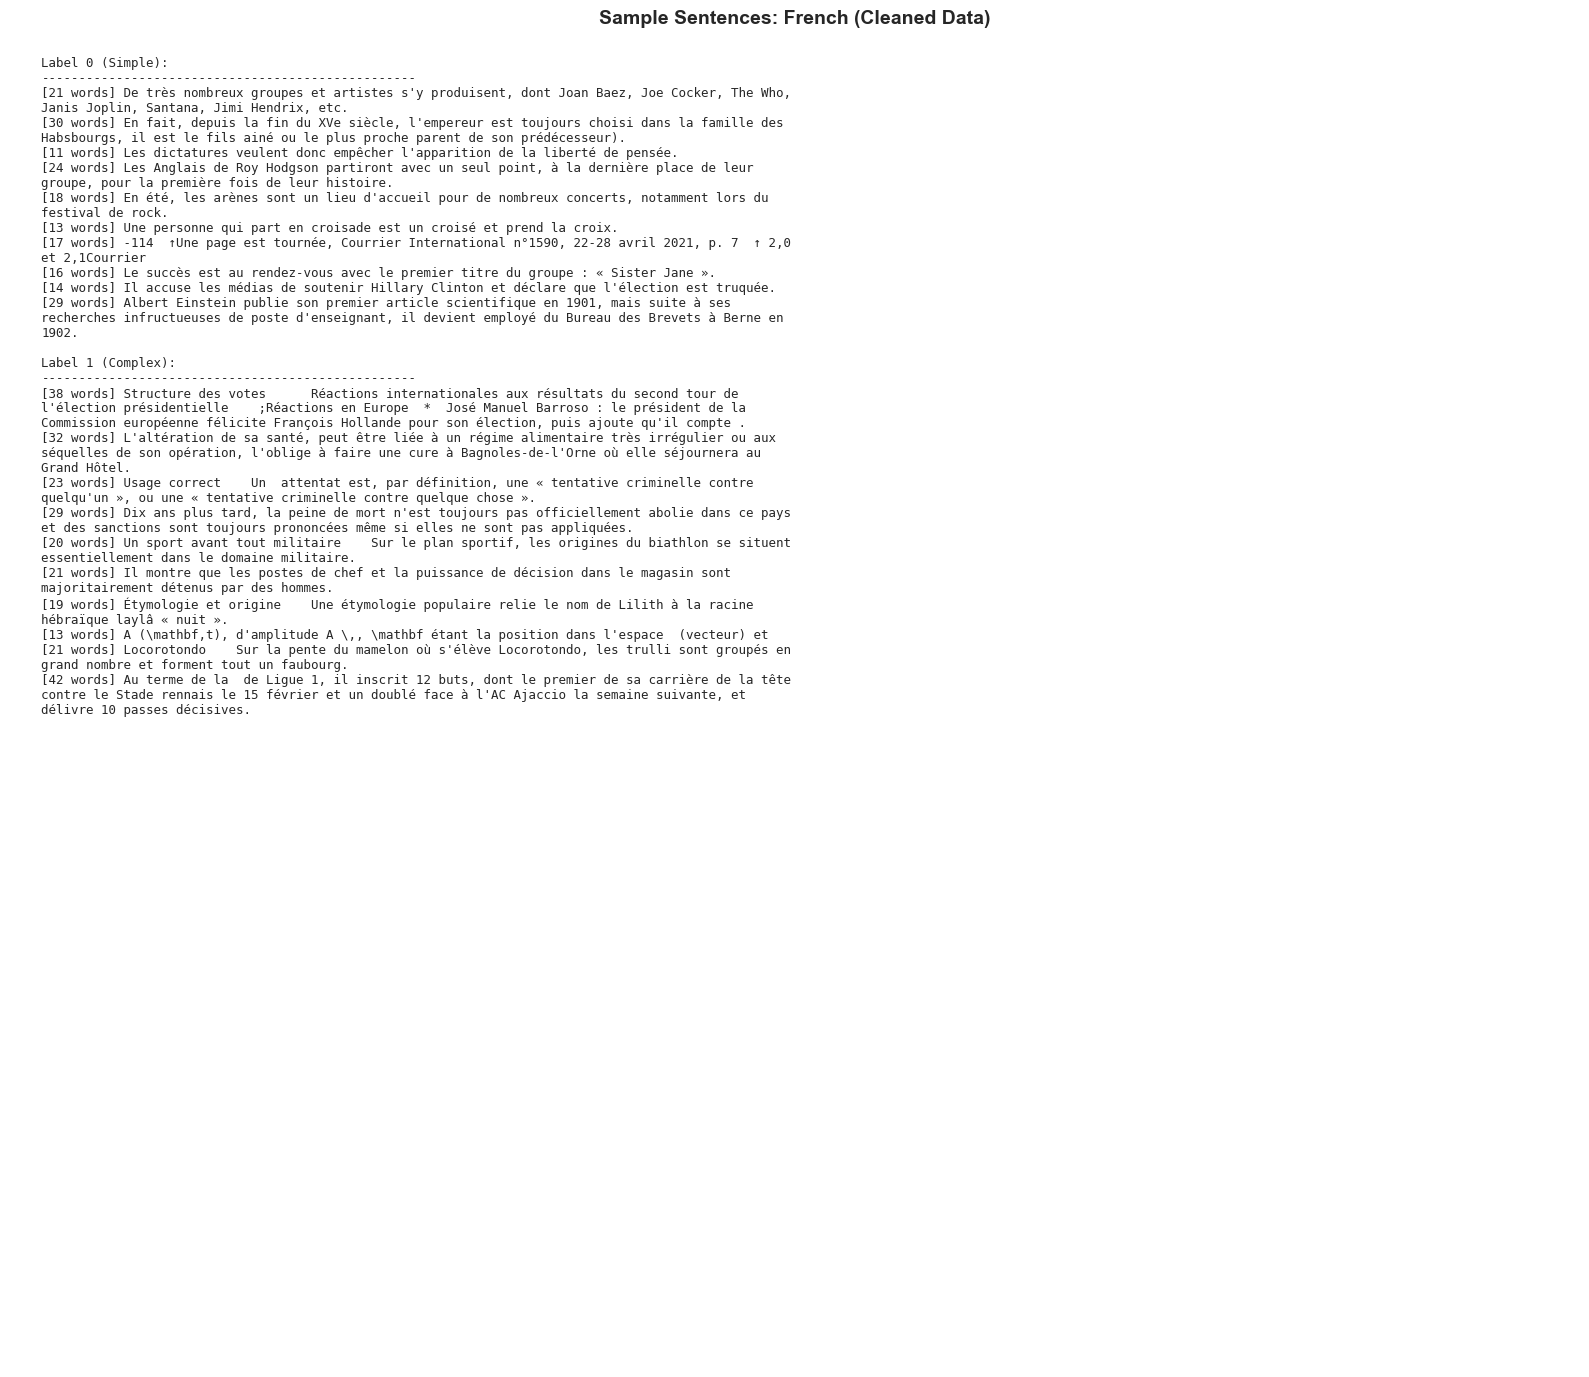

Saved: c:\Users\chang\iDEMRA\output/sample_sentences_french.png

TASK 0 COMPLETE!

Output files:
  - c:\Users\chang\iDEMRA\data/En-Dataset_cleaned.csv
  - c:\Users\chang\iDEMRA\data/Fr-Dataset_cleaned.csv
  - c:\Users\chang\iDEMRA\output/en_duplicates.csv
  - c:\Users\chang\iDEMRA\output/fr_duplicates.csv
  - c:\Users\chang\iDEMRA\output/*.png (visualizations)


In [43]:
if __name__ == "__main__":
    main()